# 🦋 ArtEvolve — Visual Edition

Genetic Algorithm for Generative Art with full visualization:
- Parent vs Offspring side-by-side view
- Best-of-generation gallery
- Animated GIF of best individuals

Run cells top-to-bottom. Tweak parameters in the **Parameters** cell.

In [1]:
import os, random, math
from PIL import Image, ImageDraw, ImageFilter, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime
os.makedirs('./artevolve_visual_outputs', exist_ok=True)
print('Output folder:', './artevolve_visual_outputs')

Output folder: ./artevolve_visual_outputs


## Parameters

In [2]:
# Tweak these
POPULATION = 12
NUM_GENERATIONS = 10
NUM_SHAPES = 12
IMAGE_SIZE = 300
MUTATION_RATE = 0.18
MUTATION_SCALE = 0.22
ELITISM = 2
SYMMETRY_PROB = 0.6   # probability that a shape is mirrored (butterfly-like)
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print('Parameters set')

Parameters set


## Genome representation

Gene format: `[shape_type, x, y, sx, sy, angle, r, g, b, a]`.
We render shapes and, with probability `SYMMETRY_PROB`, also add a mirrored shape across the vertical axis to create butterfly-like symmetry.

In [3]:
def random_gene():
    return [
        random.choice([0,1]),           # shape type (reserved)
        random.random(),                # x
        random.random(),                # y
        random.random()*0.35 + 0.02,    # sx
        random.random()*0.35 + 0.02,    # sy
        random.random()*360.0,          # angle
        random.randint(0,255),          # r
        random.randint(0,255),          # g
        random.randint(0,255),          # b
        random.random()*0.85 + 0.05      # alpha
    ]

def random_genome(num_shapes=NUM_SHAPES):
    return [random_gene() for _ in range(num_shapes)]

def clamp(v, lo, hi):
    return max(lo, min(hi, v))


## Rendering (with optional symmetry)
Each gene draws an ellipse. If `mirror=True` for that draw, a mirrored copy is also drawn at `x -> 1-x`.

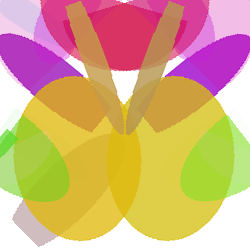

In [4]:
def render_genome(genome, size=IMAGE_SIZE, mirror_prob=SYMMETRY_PROB, blur=0):
    img = Image.new('RGBA', (size, size), (255,255,255,255))
    for gene in genome:
        stype, x, y, sx, sy, angle, r, g, b, a = gene
        cx, cy = int(x*size), int(y*size)
        rx, ry = max(1,int(sx*size)), max(1,int(sy*size))
        # draw main shape
        layer = Image.new('RGBA', (size, size), (0,0,0,0))
        draw = ImageDraw.Draw(layer)
        bbox = [cx-rx, cy-ry, cx+rx, cy+ry]
        draw.ellipse(bbox, fill=(int(r),int(g),int(b),int(255*a)))
        if abs(angle) > 0.001:
            layer = layer.rotate(angle, resample=Image.BICUBIC, center=(cx,cy), expand=False)
        img = Image.alpha_composite(img, layer)
        # mirrored shape
        if random.random() < mirror_prob:
            mx = 1.0 - x
            mcx, mcy = int(mx*size), int(y*size)
            mlayer = Image.new('RGBA', (size, size), (0,0,0,0))
            mdraw = ImageDraw.Draw(mlayer)
            mbbox = [mcx-rx, mcy-ry, mcx+rx, mcy+ry]
            # slightly perturb color/alpha for variety
            mr = clamp(int(r + np.random.normal(scale=8)), 0, 255)
            mg = clamp(int(g + np.random.normal(scale=8)), 0, 255)
            mb = clamp(int(b + np.random.normal(scale=8)), 0, 255)
            ma = clamp(a + np.random.normal(scale=0.03), 0.02, 0.98)
            mdraw.ellipse(mbbox, fill=(mr,mg,mb,int(255*ma)))
            if abs(angle) > 0.001:
                mlayer = mlayer.rotate(-angle, resample=Image.BICUBIC, center=(mcx,mcy), expand=False)
            img = Image.alpha_composite(img, mlayer)
    if blur and blur>0:
        img = img.filter(ImageFilter.GaussianBlur(radius=blur))
    background = Image.new('RGB', img.size, (255,255,255))
    background.paste(img, mask=img.split()[3])
    return background

# quick render test
display(render_genome(random_genome(), size=250))

## Fitness functions
We use contrast + symmetry. Higher is better.

In [5]:
def fitness_contrast_symmetry(pil_img):
    img = pil_img.convert('L').resize((120,120))
    arr = np.array(img).astype(np.float32)
    contrast = arr.std()
    w = arr.shape[1]
    left = arr[:, :w//2]
    right = np.fliplr(arr[:, w - w//2:])
    minw = min(left.shape[1], right.shape[1])
    left = left[:, :minw]
    right = right[:, :minw]
    sym_diff = np.mean(np.abs(left - right))
    return float(contrast - 0.8*sym_diff)

def fitness_entropy(pil_img):
    img = pil_img.convert('L').resize((128,128))
    hist = np.array(img.histogram(), dtype=float)
    hist = hist / hist.sum()
    hist = hist[hist>0]
    return float(-np.sum(hist * np.log2(hist)))

print('Fitness functions ready')

Fitness functions ready


## GA operators (selection, crossover, mutation)

In [6]:
def evaluate_population(pop, renderer=render_genome, scorer=fitness_contrast_symmetry):
    imgs = [renderer(g) for g in pop]
    fits = np.array([scorer(im) for im in imgs])
    return imgs, fits

def tournament_select(pop, fits, k=3):
    idx = np.random.randint(0, len(pop), size=k)
    return pop[int(idx[np.argmax(fits[idx])])]

def crossover(pa, pb):
    # gene-level uniform crossover
    child = []
    for ga, gb in zip(pa, pb):
        child.append(list(ga) if random.random()<0.5 else list(gb))
    return child

def mutate(genome, rate=MUTATION_RATE, scale=MUTATION_SCALE):
    for gene in genome:
        if random.random() < rate:
            field = random.randrange(len(gene))
            if field == 0:
                gene[0] = random.choice([0,1])
            elif field in [1,2]:
                gene[field] = clamp(gene[field] + np.random.normal(scale=scale), 0.0, 1.0)
            elif field in [3,4]:
                gene[field] = clamp(gene[field] + np.random.normal(scale=scale), 0.005, 0.5)
            elif field == 5:
                gene[field] = (gene[field] + np.random.normal(scale=scale*180)) % 360
            elif field in [6,7,8]:
                gene[field] = int(clamp(int(gene[field] + np.random.normal(scale=scale*255)), 0, 255))
            elif field == 9:
                gene[field] = clamp(gene[field] + np.random.normal(scale=scale), 0.02, 0.98)
    return genome

print('GA operators ready')

GA operators ready


## Visualization helpers
Functions to show population grid, parent-offspring pairs, and save images.

In [7]:
def show_population_grid(images, cols=4, thumb=150, title=None):
    rows = math.ceil(len(images)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    axs = np.array(axs).reshape(-1)
    for ax in axs: ax.axis('off')
    for i, im in enumerate(images):
        axs[i].imshow(im)
    if title:
        fig.suptitle(title)
    plt.show()

def show_parent_offspring(parent, offspring, figsize=(6,3)):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    axs[0].imshow(parent); axs[0].set_title('Parent (selected)'); axs[0].axis('off')
    axs[1].imshow(offspring); axs[1].set_title('Offspring'); axs[1].axis('off')
    plt.show()

def save_image(img, path):
    img.save(path)


## Run evolution with full visualization
This cell runs the GA and after each generation:
- displays the population grid
- shows the best individual
- shows a parent-offspring pair for demonstration
- saves best images and finally creates a GIF

Gen 00  best score: 39.768


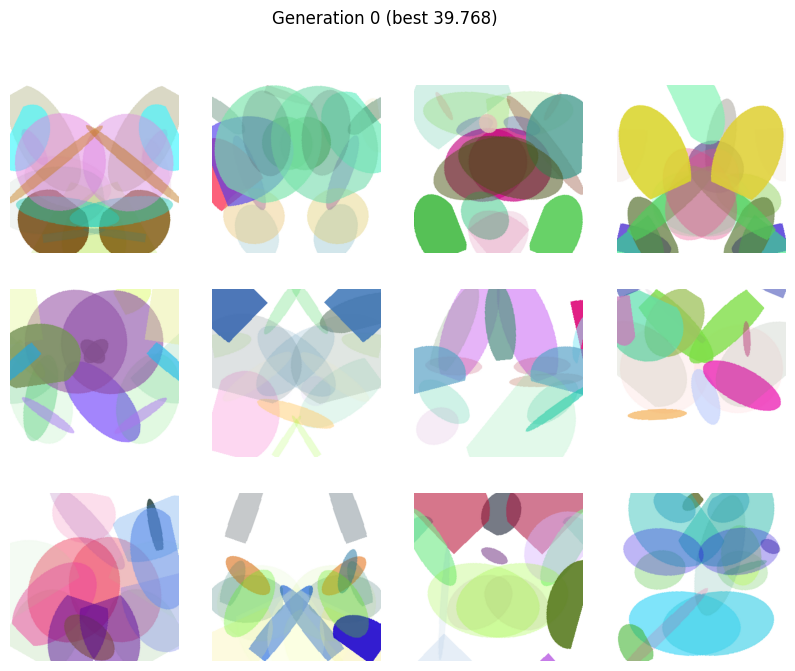

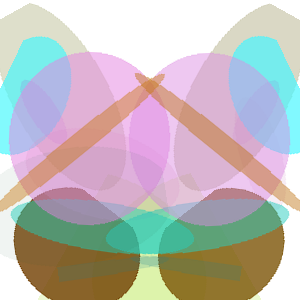

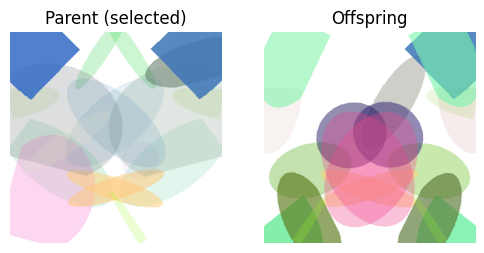

Gen 01  best score: 47.863


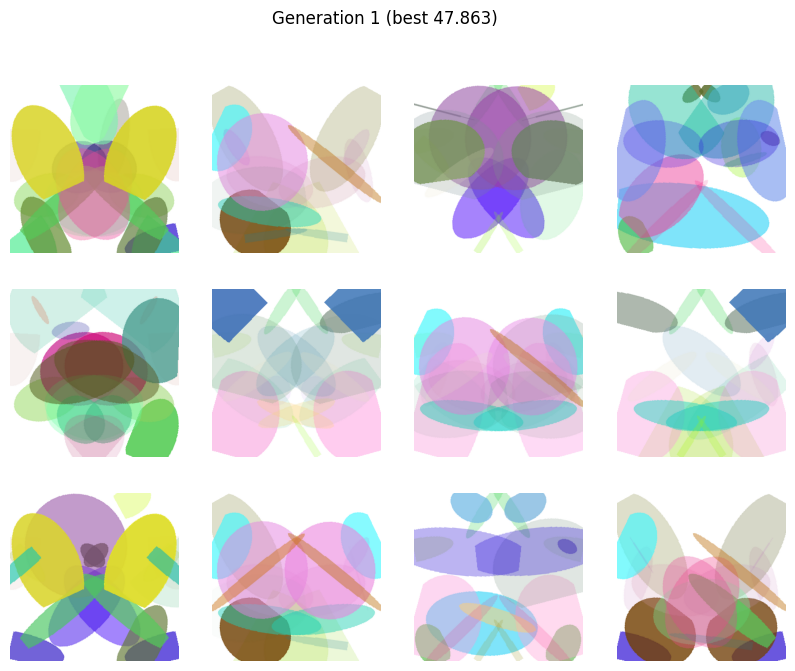

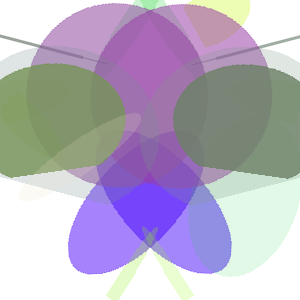

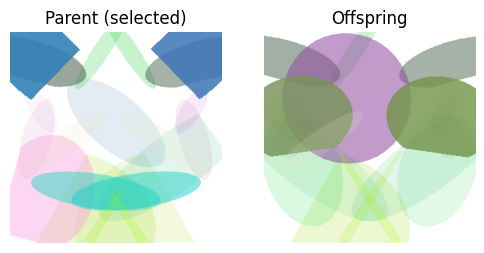

Gen 02  best score: 47.176


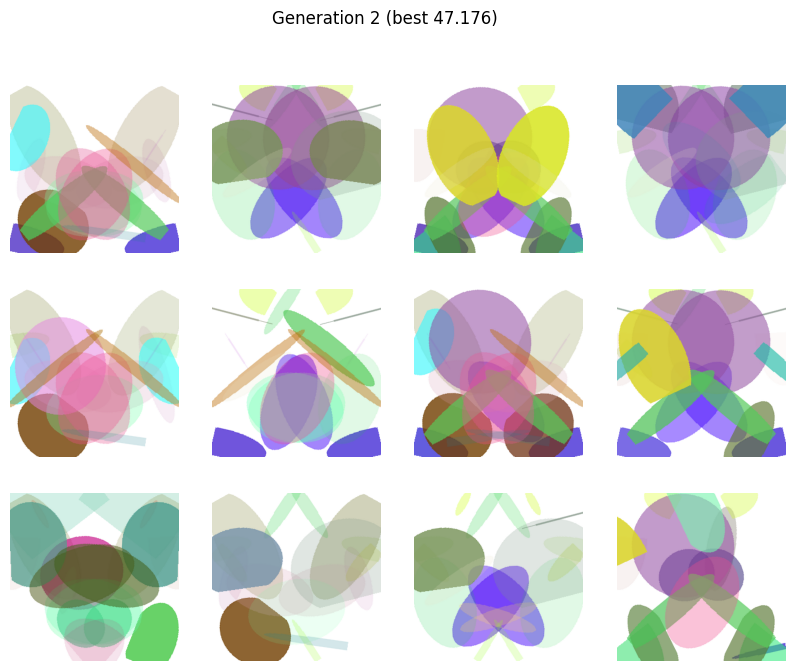

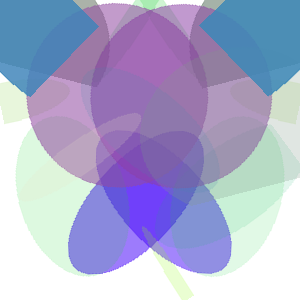

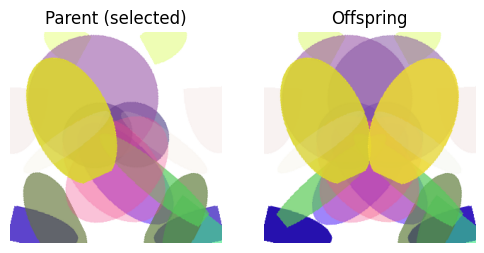

Gen 03  best score: 48.553


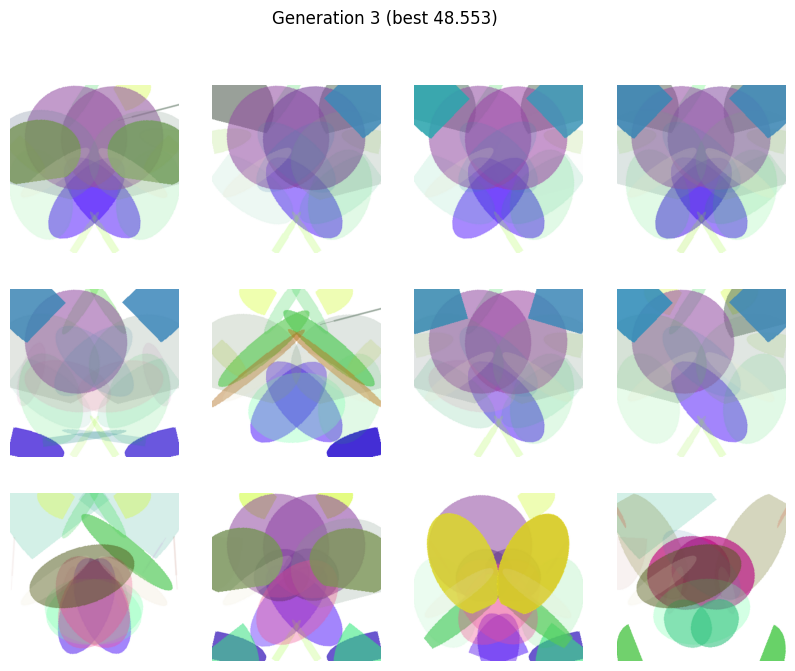

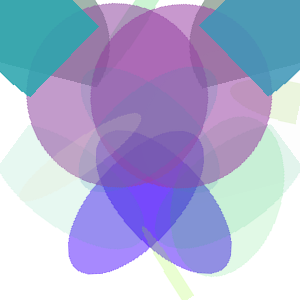

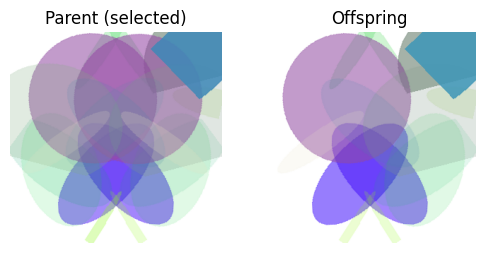

Gen 04  best score: 45.841


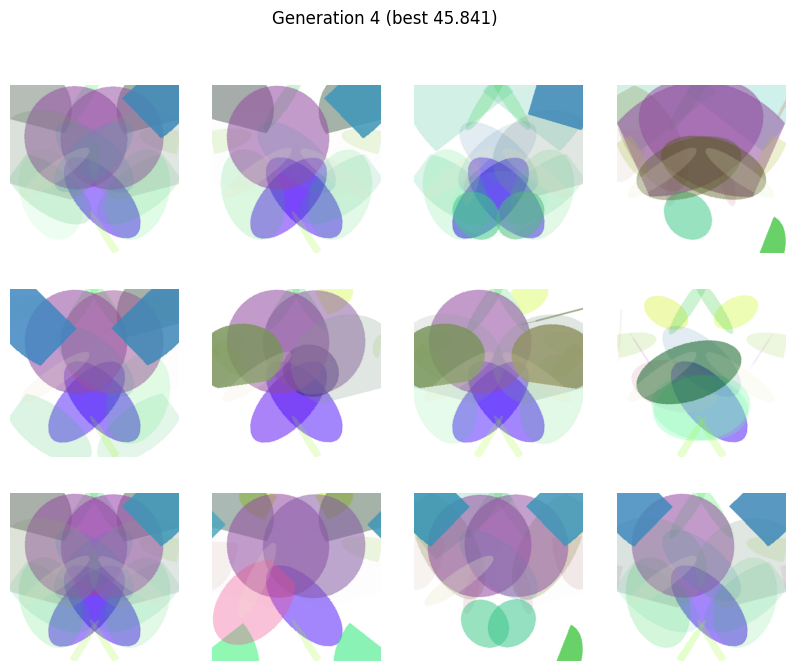

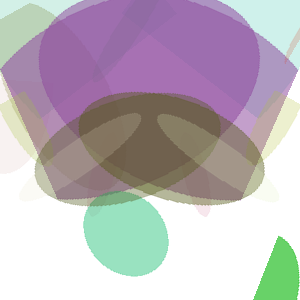

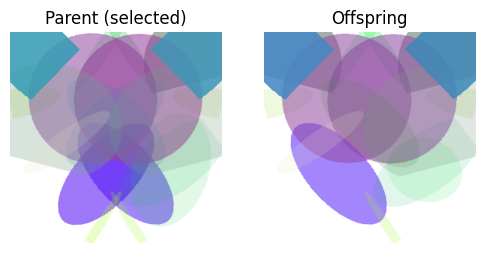

Gen 05  best score: 50.729


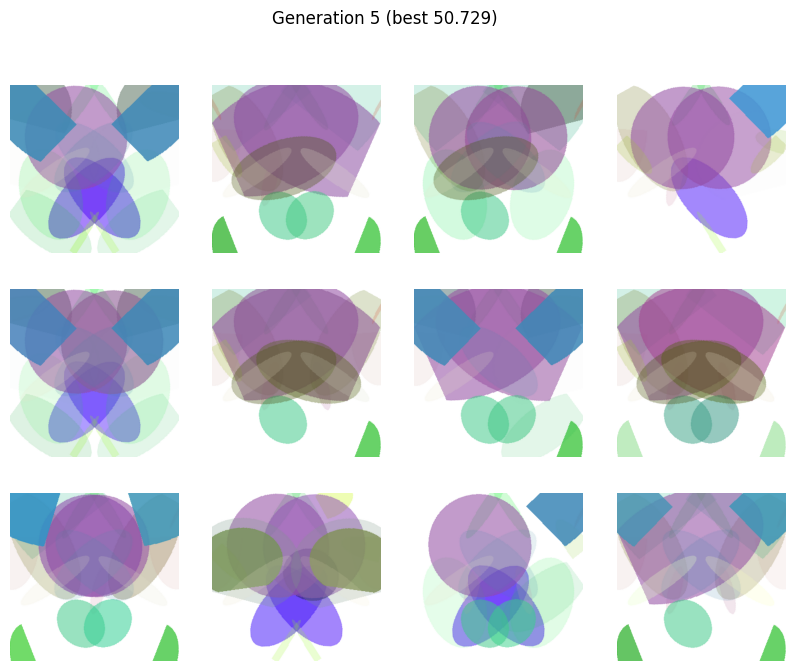

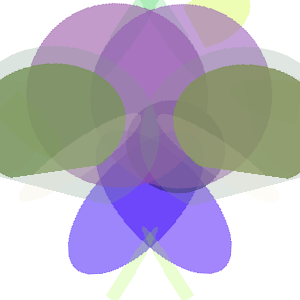

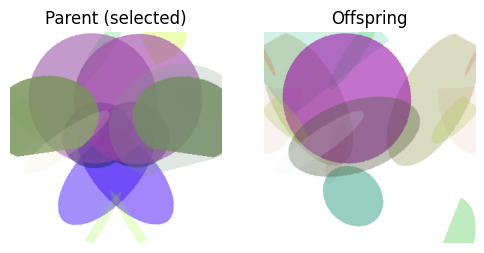

Gen 06  best score: 56.165


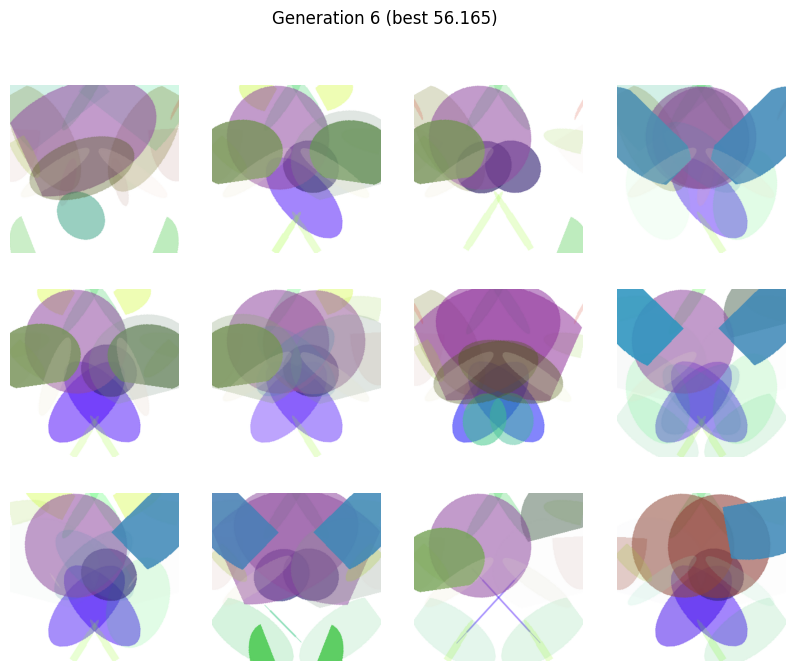

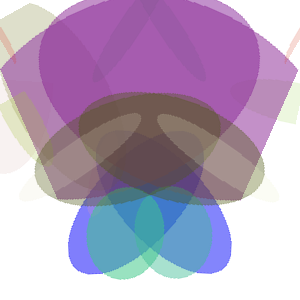

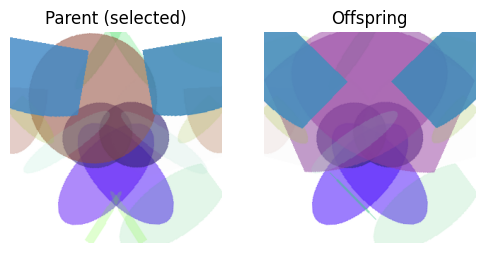

Gen 07  best score: 53.159


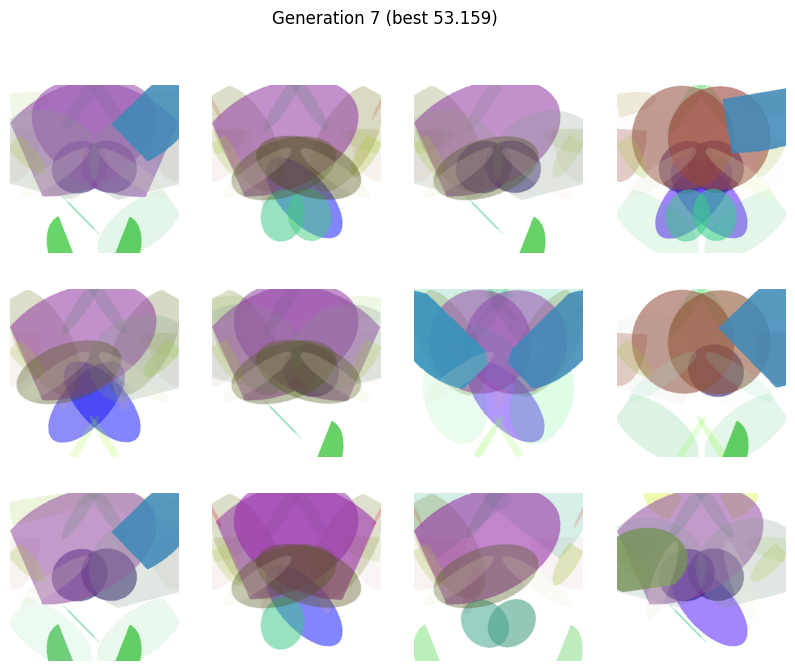

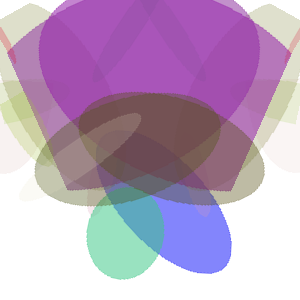

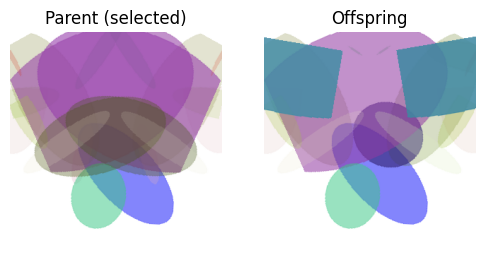

Gen 08  best score: 51.259


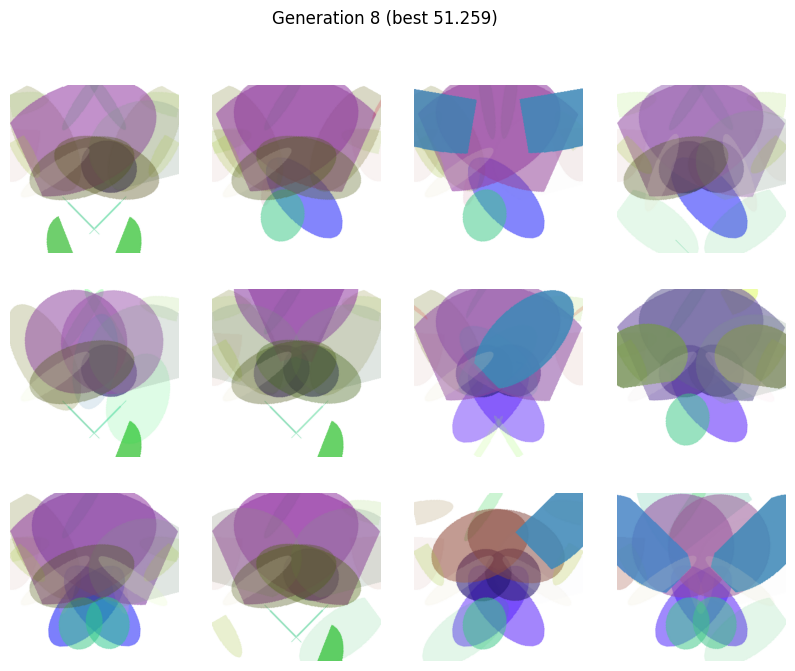

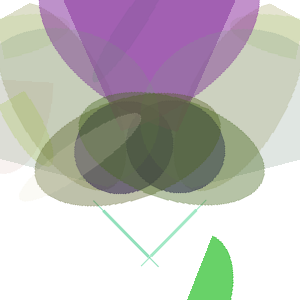

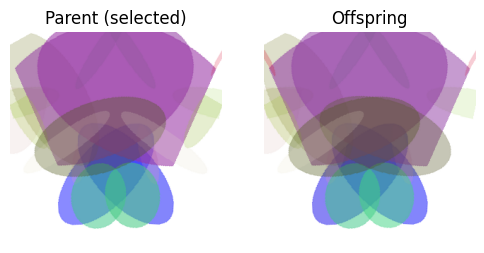

Gen 09  best score: 54.649


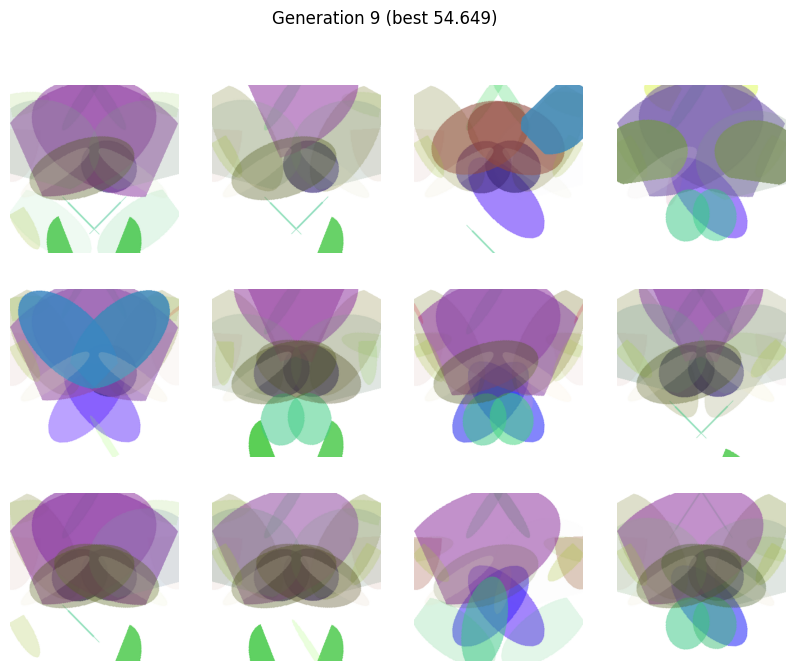

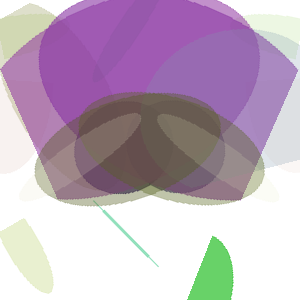

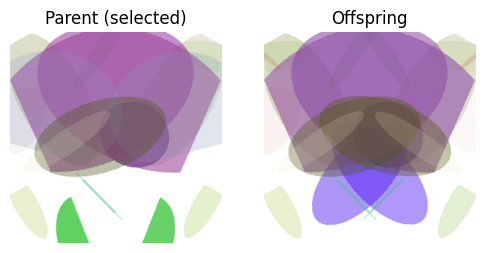

Saved GIF to ./artevolve_visual_outputs\run_20251107_111338\best_evolution.gif
Run directory: ./artevolve_visual_outputs\run_20251107_111338


In [8]:
def run_evolution_visual(pop_size=POPULATION, generations=NUM_GENERATIONS, out_folder='./artevolve_visual_outputs'):
    pop = [random_genome() for _ in range(pop_size)]
    best_history = []
    best_paths = []
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_dir = os.path.join(out_folder, f'run_{ts}')
    os.makedirs(run_dir, exist_ok=True)
    for gen in range(generations):
        imgs, fits = evaluate_population(pop)
        best_idx = int(np.argmax(fits))
        best_img = imgs[best_idx]
        print(f'Gen {gen:02d}  best score: {fits[best_idx]:.3f}')
        # show population grid
        show_population_grid(imgs, cols=4, title=f'Generation {gen} (best {fits[best_idx]:.3f})')
        # show best
        display(best_img)
        # choose a parent to show vs offspring
        # select two parents by tournament
        pa = tournament_select(pop, fits)
        pb = tournament_select(pop, fits)
        child = mutate(crossover(pa, pb))
        child_img = render_genome(child)
        show_parent_offspring(render_genome(pa), child_img)
        # save best
        best_path = os.path.join(run_dir, f'best_gen_{gen:02d}.png')
        save_image(best_img, best_path)
        best_paths.append(best_path)
        best_history.append(float(fits[best_idx]))
        # build next generation
        new_pop = []
        elite_idx = np.argsort(fits)[-ELITISM:]
        for ei in elite_idx:
            new_pop.append([list(g) for g in pop[int(ei)]])
        while len(new_pop) < pop_size:
            pa = tournament_select(pop, fits)
            pb = tournament_select(pop, fits)
            c = crossover(pa, pb)
            c = mutate(c)
            new_pop.append(c)
        pop = new_pop
    # create GIF from best_paths
    gif_path = os.path.join(run_dir, 'best_evolution.gif')
    try:
        frames = [Image.open(p).convert('RGB') for p in best_paths]
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=700, loop=0)
        print('Saved GIF to', gif_path)
    except Exception as e:
        print('Failed to write GIF:', e)
        gif_path = None
    return run_dir, best_history, best_paths, gif_path

run_dir, history, best_paths, gif = run_evolution_visual()
print('Run directory:', run_dir)

## Show GIF inline (if created)

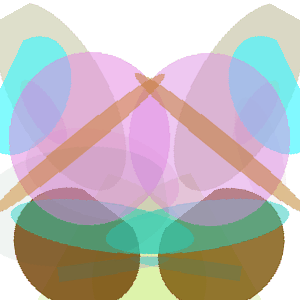

In [9]:
from IPython.display import Image as IPyImage
if 'gif' in globals() and gif:
    display(IPyImage(gif))
else:
    print('No GIF created or not available')

In [ ]:
print('Notebook file saved to /mnt/data/ArtEvolve_visual.ipynb')